In [1]:
# データ加工・処理・分析ライブラリ
import numpy as np
import numpy.random as random
import scipy as sp
from pandas import Series, DataFrame
import pandas as pd

# 可視化ライブラリ
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

# 機械学習ライブラリ
import sklearn

# 小数第三位まで表示
%precision 3

'%.3f'

<span style="font-size: 200%">分類モデルの評価指標：混同行列と関連指標</span>

In [3]:
# インポート
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer

# 乳がんのデータ読み込み
cancer = load_breast_cancer()

# 訓練データとテストデータに分類
X_train, X_test, y_train, y_test = train_test_split(cancer.data, 
                                                    cancer.target, 
                                                    stratify = cancer.target, 
                                                    random_state = 66)

# クラスの初期化と学習
model = SVC(gamma=0.001, C=1)
model.fit(X_train, y_train)

# 表示
print('{} train score: {:.3f}'.format(model.__class__.__name__, model.score(X_train, y_train)))
print('{} test score: {:.3f}'.format(model.__class__.__name__, model.score(X_test, y_test)))


SVC train score: 0.979
SVC test score: 0.909


**混同行列**

In [6]:
'''
この方法で出力される混同行列は縦が実測、横が予測
'''

# インポート
from sklearn.metrics import confusion_matrix

# テストデータを使って予測値を算出
y_pred = model.predict(X_test)

m = confusion_matrix(y_test, y_pred)
print('Confusion matrix:\n{}'.format(m))

Confusion matrix:
[[48  5]
 [ 8 82]]


**正解率、適合率、再現率、F1スコア**

In [8]:
# 全体に対して、正しく予測できている割合
accuracy = (m[0,0] + m[1,1]) / m.sum()
print('正解率:{:.3f}'.format(accuracy))

# 予測した全件に対して、正しく予測できている割合
precision = m[1,1] / m[:,1].sum()
print('適合率:{:.3f}'.format(precision))

# 実際の１（事象が発生した）全件に対して、正しく予測できている割合
recall = m[1,1] / m[1,:].sum()
print('再現率:{:.3f}'.format(recall))

# 適合率と再現率の調和平均
# 適合率と再現率のどちらを用いるか決まっていない場合に、総合的に判断する際に使用
f1 = 2 * (precision * recall) / (precision + recall)
print('F1値:{:.3f}'.format(f1))


正解率:0.909
適合率:0.943
再現率:0.911
F1値:0.927


In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score
print('適合率:{:.3f}'.format(precision_score(y_test, y_pred)))
print('再現率:{:.3f}'.format(recall_score(y_test, y_pred)))
print('F1値:{:.3f}'.format(f1_score(y_test, y_pred)))

適合率:0.943
再現率:0.911
F1値:0.927


<span style="font-size: 200%">分類モデルの評価指標：ROC曲線とAUC</span>

In [16]:
# インポート
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import cross_validate

# 乳がんのデータ読み込み
cancer = load_breast_cancer()

# 訓練データとテストデータに分類
X_train, X_test, y_train, y_test = train_test_split(cancer.data, 
                                                    cancer.target, 
                                                    stratify = cancer.target, 
                                                    random_state = 66)

# Logisticクラスの初期化と学習
model = LogisticRegression(solver='liblinear', random_state=0)
model.fit(X_train, y_train)

# テスト用データの予測確率を計算
results = pd.DataFrame(model.predict_proba(X_test), columns=cancer.target_names)
results.head()


,malignant,benign
0,0.003753,0.996247
1,0.000525,0.999475
2,0.027698,0.972302
3,0.007188,0.992812
4,0.003221,0.996779


In [17]:
# 良性クラスの予測確率が0.4,0.3,0.15,0.05以上なら、それぞれの列に1を設定する
for threshold in [0.4,0.3,0.15,0.05]:
    results[f'flag_{threshold}'] = results['benign'].map(lambda x: 1 if x > threshold else 0)

results.head(10)


,malignant,benign,flag_0.4,flag_0.3,flag_0.15,flag_0.05
0,0.003753,0.996247,1,1,1,1
1,0.000525,0.999475,1,1,1,1
2,0.027698,0.972302,1,1,1,1
3,0.007188,0.992812,1,1,1,1
4,0.003221,0.996779,1,1,1,1
5,0.008857,0.991143,1,1,1,1
6,0.006011,0.993989,1,1,1,1
7,0.003220,0.996780,1,1,1,1
8,0.917868,0.082132,0,0,0,1
9,0.817335,0.182665,0,0,1,1


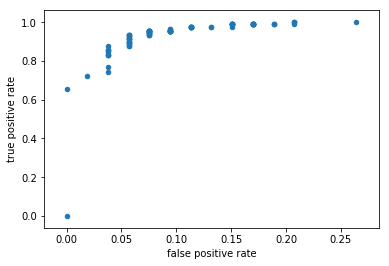

In [18]:
'''
ROC曲線
縦軸に真陽性比率（再現率）、横軸に偽陽性比率をプロット
'''
# 閾値を0.01から1.00までの間で100通りとして、偽陽性率と新陽性率を計算
rates = {}
for threshold in np.linspace(0.01, 1.00, num=100):
    labels = results['benign'].map(lambda x: 1 if x > threshold else 0)
    m = confusion_matrix(y_test, labels)
    rates[threshold] = {'false positive rate': m[0,1] / m[0,:].sum(),
                         'true positive rate': m[1,1] / m[1,:].sum()}

# プロット
pd.DataFrame(rates).T.plot.scatter('false positive rate', 'true positive rate')
    

**ROC曲線(モジュール関数)**

In [21]:
# インポート
from sklearn import svm
from sklearn.metrics import roc_curve, auc
from sklearn.datasets import load_breast_cancer

# 乳がんのデータ読み込み
cancer = load_breast_cancer()

# 訓練データとテストデータに分類
X_train, X_test, y_train, y_test = train_test_split(cancer.data, 
                                                    cancer.target, 
                                                    stratify = cancer.target, 
                                                    random_state = 66)

# SVCによる予測確率の取得
model = svm.SVC(kernel='linear', probability=True, random_state=0)
model.fit(X_train, y_train)

# 予測確率を取得
y_pred = model.predict_proba(X_test)[:,1]


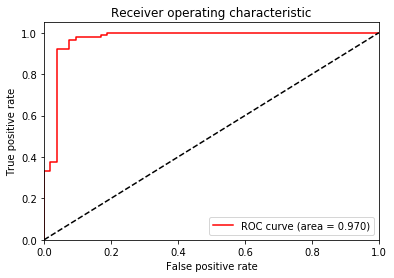

In [23]:
# 偽陽性率、真陽性率の算出
fpr, tpr, threshold = roc_curve(y_test, y_pred)

# AUCの算出
auc = auc(fpr, tpr)

# ROC曲線の描画
plt.plot(fpr, tpr, color='red', label='ROC curve (area = %.3f)' % auc)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="best")